In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from numba import jit, types
from scipy.sparse import diags
matplotlib.rcParams['animation.embed_limit'] = 2**128

from Wave_func_propagation import *
from Animation_func import *
from Transmiton_prob import *
from Fourier_transform import *

In [2]:
elementary_charge = 1.602176634e-19
hbar = 1.054571817e-34 # J s
m = 9.1093837015e-31 # kg
#m = 0.510998950e6
Energi_init = 17.5e-3 * elementary_charge# J
sigma_x = 200e-10
x_s = 40e-8
k_0 = np.sqrt(2*m*Energi_init)/hbar

L = 1200e-9

well_size = 6e-9
barrier_size = 1.2e-9
barrier_hight = 90e-3*elementary_charge


Potential_size = np.array([barrier_size, well_size, barrier_hight,0,0])




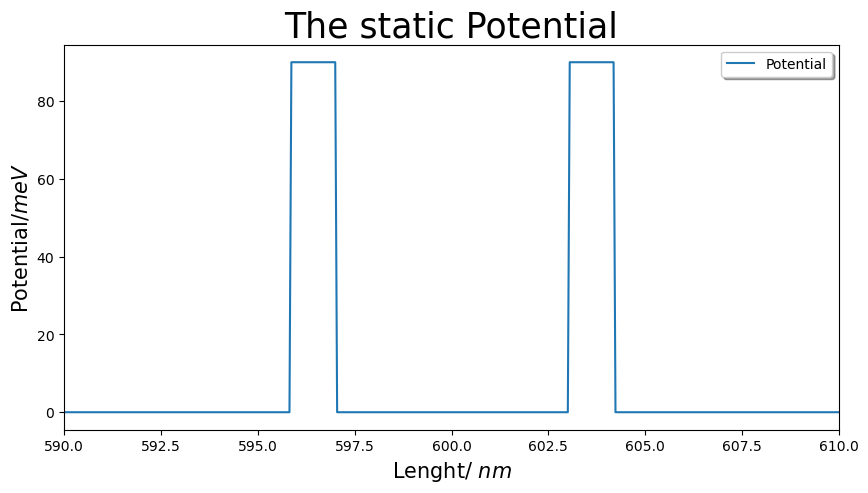

In [3]:
def Two_Potential_Barrier(x_axis, dx, time, Potential):

    #pot = np.zeros((len(time), len(x_axis)))
    pot = np.zeros(len(x_axis))
    middel = len(x_axis)/2 *dx
    barrier = Potential[0]
    well = Potential[1]

    left_edge_left = middel - (well/2 + barrier)
    righ_edge_left = middel - (well/2)
    left_edge_righ = middel + (well/2)
    righ_edge_righ = middel + (well/2 + barrier)
    # print(left_edge_left)

    righ_edge_righ_i = np.searchsorted(x_axis, righ_edge_righ, side='right')
    left_edge_righ_i = np.searchsorted(x_axis, left_edge_righ, side='right')
    righ_edge_left_i = np.searchsorted(x_axis, righ_edge_left, side='right')
    left_edge_left_i = np.searchsorted(x_axis, left_edge_left, side='right')

    pot[left_edge_left_i : righ_edge_left_i], pot[left_edge_righ_i : righ_edge_righ_i] = Potential[2], Potential[2]
    
    # const = Potential[4] *dt 

    # left_well_edge = middel - well/2
    # righ_well_edge = middel + well/2

    # left_well_edge_i = np.searchsorted(x_axis, left_well_edge, side='righ')
    # righ_well_edge_i = np.searchsorted(x_axis, righ_well_edge, side='righ')
    # print(pot.shape, left_well_edge_i,righ_well_edge_i)

    # pot[left_well_edge_i : righ_well_edge_i] = 10*Potential[3]*np.cos(const * time)

    return pot, Potential[2]



N_x = 15*int(2*k_0*L) + 1 
dx = L/(N_x-1)
v_g = hbar * k_0/m
x_axis = np.linspace(0.0, L, N_x, dtype=np.float64)

dt = 0.1 * hbar / ((hbar**2/(2*m*dx**2))+Potential_size[2])
T = 1.4*L/(2*v_g)
N_t = int(T/dt)
time =  np.linspace(0,T,N_t)
Potential_size = np.array([barrier_size, well_size, barrier_hight,5e-3 * elementary_charge,5e-3 * elementary_charge])
pot, v_max = Two_Potential_Barrier(x_axis, dx, time[-1], Potential_size)

plt.figure(figsize=(10,5))
plt.title('The static Potential', fontsize=25)
plt.plot(x_axis*1e9,pot/elementary_charge*1e3, label = 'Potential')
plt.xlim(590,610)
plt.xlabel('Lenght/ $nm$', fontsize=15)
plt.ylabel('Potential/${meV}$', fontsize=15)
plt.legend(shadow=True, loc='upper right')
plt.show()


In [4]:
Psi_t1, psi_imag_t1, psi_real_t1, x, dx, T, N_t, harm_pot_animat = Psi_propagation(Psi_initial, Two_Potential_Barrier, sigma_x, x_s, hbar, m, L, k_0,
                                                                Potential_size, t_dep_pot=False)

time_redused = 1#np.linspace(0,T,int(N_t/1000+3))



pot_barriers, v_max = Two_Potential_Barrier(x, dx, time_redused, Potential_size)

probability_tot, normalisation_trans, normalisation_reflec = probability_density(Psi_t1, -1, dx, Potential_size, x)


a,b,c=probability_density(Psi_t1, -1, dx, Potential_size, x)
print('Transmission probability is:',b*100,'%')



Transmission probability is: 0.23200076540550676 %


In [5]:
print(Psi_t1.shape)
ani = animate_system(elementary_charge, x, pot_barriers, np.abs(Psi_t1),  4e38, limits = [-0.01e-6,1.61e-6, -15, 10000])
HTML(ani.to_jshtml())


(4048, 24391)


KeyboardInterrupt: 

In [ ]:
plt.plot(x,np.abs(Psi_t1[14])**2)
# plt.xlim(0.75e-6,1.25e-6)
# plt.ylim(0,3e6)



In [6]:
def Fourier_transformed1(Wave, Desired_t, Dx, hbar, mass, x_axis, pot_size):

    left_barier, right_barier = int(len(x_axis)/2  - pot_size[0]/Dx - pot_size[1]/(Dx*2)), int(len(x_axis)/2  + pot_size[0]/Dx + pot_size[1]/(Dx*2))
    x_reflected = x_axis[:left_barier]
    x_transmited = x_axis[right_barier:]
    # print(int(len(x_axis)/2 - 500), left_barier*dx, right_barier*dx)

    Transformed_total = np.fft.fft(Wave[Desired_t,:],n=1000000)
    Transformed_reflected = np.fft.fft(Wave[Desired_t,:left_barier],n=1000000)
    Transformed_transmited = np.fft.fft(Wave[Desired_t,right_barier:],n=1000000)

    N = len(Transformed_total)
    freq = np.fft.fftfreq(N, Dx)

    firstNegInd = np.argmax(freq < 0)
    # freq_r = freq[firstNegInd:]
    freq = freq[:firstNegInd]
    Transformed_reflected = Transformed_reflected[::-1]
    Transformed_reflected =  Transformed_reflected[:firstNegInd]
    Transformed_transmited = Transformed_transmited[:firstNegInd]

    '''
    k_vec_sum_left = 0
    k_vec_sum_right = 0
    n = 0  
     
    test_count = 0
    test = 0
    #for i in range(0,int(N/2),1):
    for i in range(len(Transformed_reflected)):
        if np.abs(Transformed_reflected[i]) > 500:

            n +=1
            k_vec_sum_left += np.abs(freq[i])

    excepted_value_k_left = -(k_vec_sum_left*2*np.pi)/n
    Excpeted_Energi_left = (hbar * excepted_value_k_left)**2/(2*mass)
    #print(excepted_value_k_left, 'left', np.median(freq), Excpeted_Energi_left)


    
    n_righ = 0
    for i in range(len(Transformed_transmited)):
        if np.abs(Transformed_transmited[i]) > 1200:

            n_righ +=1
            k_vec_sum_right += (freq[i])
        
    if n_righ != 0:
        excepted_value_k_right = (k_vec_sum_right*2*np.pi)/n_righ
        Excpeted_Energi_right = (hbar * excepted_value_k_right)**2/(2*mass) 
        #print(excepted_value_k_right, 'right')

    else:
        Excpeted_Energi_right, excepted_value_k_right = 0.0, 0.0

    

    Excpeted_Energi_tot = np.mean([Excpeted_Energi_right, Excpeted_Energi_left]) #(hbar * (excepted_value_k_left + excepted_value_k_right))**2/(2*mass)
    #print((hbar * np.mean([excepted_value_k_right, excepted_value_k_left]))**2/(2*mass),'kkkkkkkkkk')



    n = 0
    k_vec_sum_total = 0
    d = np.where(Transformed_total==np.max(Transformed_total))[0][0]
    print(d)
    for i in range(len(Transformed_total)):
        if np.abs(Transformed_total[i]) > 1:

            n +=1
            k_vec_sum_total += (freq[i])

    excepted_value_k = (k_vec_sum_total*2*np.pi)/n
    Excpeted_Energi = (hbar * excepted_value_k)**2/(2*mass)
    # print(Excpeted_Energi,'total')
    if n_righ !=0:
        print('Excpeted Energy tot:', Excpeted_Energi_tot, 'Excpeted Energy left:', Excpeted_Energi_left,'Excpeted Energy right:', Excpeted_Energi_right)    
    else:
        print('Excpeted Energy tot:', Excpeted_Energi, 'Excpeted Energy left:', Excpeted_Energi_left,'Excpeted Energy right:', Excpeted_Energi_right)    
    '''
    
    freq = freq*2*np.pi
    # freq_r = freq_r*2*np.pi

    
    return Transformed_reflected, Transformed_transmited, Transformed_total, freq, #freq_r#, Excpeted_Energi_tot

In [5]:
Transformed_reflected, Transformed_transmited, Transformed_total, freq = Fourier_transformed(Psi_t1, -1 , dx , hbar, m, x, Potential_size)
print(Energi_init, k_0)

2.8038091095000002e-21 677731319.8281631


In [6]:
# plt.figure(figsize=(17,7))
# # plt.plot(freq, Transformed_total, label = 'Total')
# plt.plot(freq, np.abs(Transformed_reflected), label = 'Reflected')
# plt.plot(freq, np.abs(Transformed_transmited), label = 'Transmited')
# # plt.xlim(-2e9, 2e9)
# # plt.ylim(-10000,10000)
# plt.legend()
# plt.show()




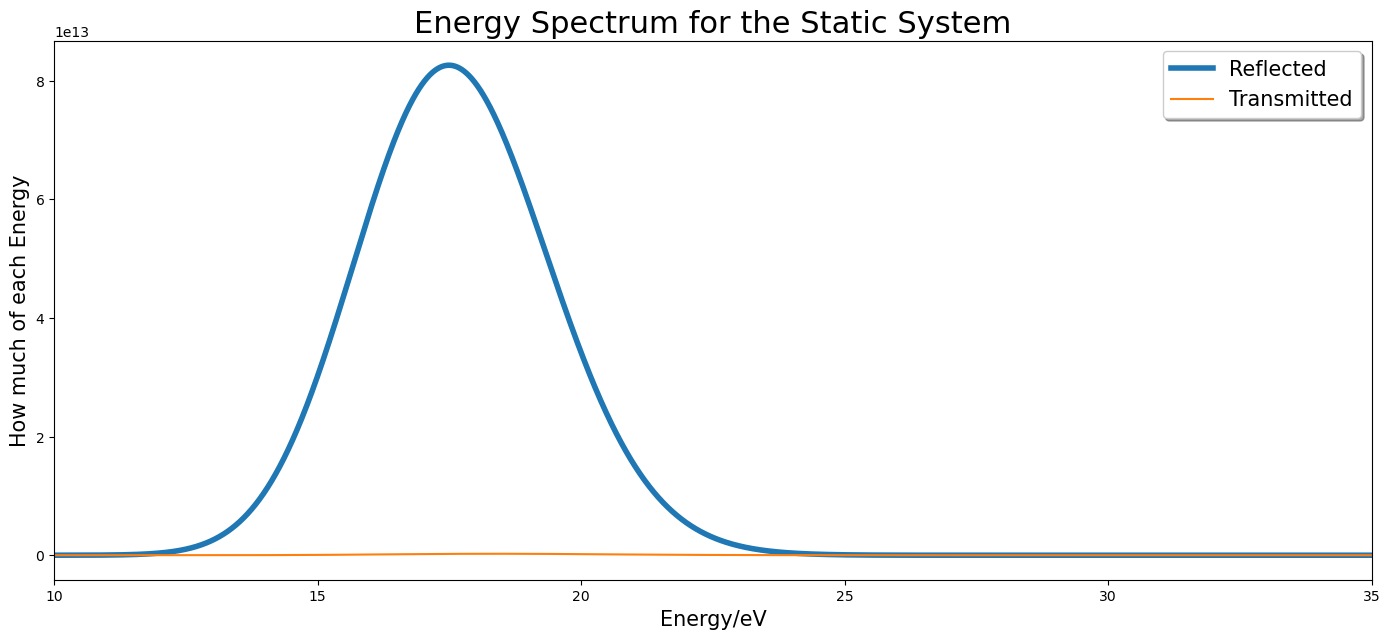

In [7]:

Energi_specture = ( (freq)* hbar)**2/(2 * m)




plt.figure(figsize=(17,7))
plt.title('Energy Spectrum for the Static System', fontsize= 22)
# plt.plot(Energi_specture/elementary_charge, np.abs(Transformed_total)**2, label = 'Total')
plt.plot(np.abs(Energi_specture)/elementary_charge*1e3, np.abs(Transformed_reflected)**2, linewidth=4, label = 'Reflected')
plt.plot(Energi_specture/elementary_charge*1e3, np.abs(Transformed_transmited)**2, label = 'Transmitted')
plt.xlim(10, 35)
# plt.ylim(-10000,10000)
plt.xlabel('Energy/eV', fontsize= 15)
plt.ylabel('How much of each Energy', fontsize= 15)
plt.legend(shadow=True, loc='upper right', prop={'size': 15})
plt.show()

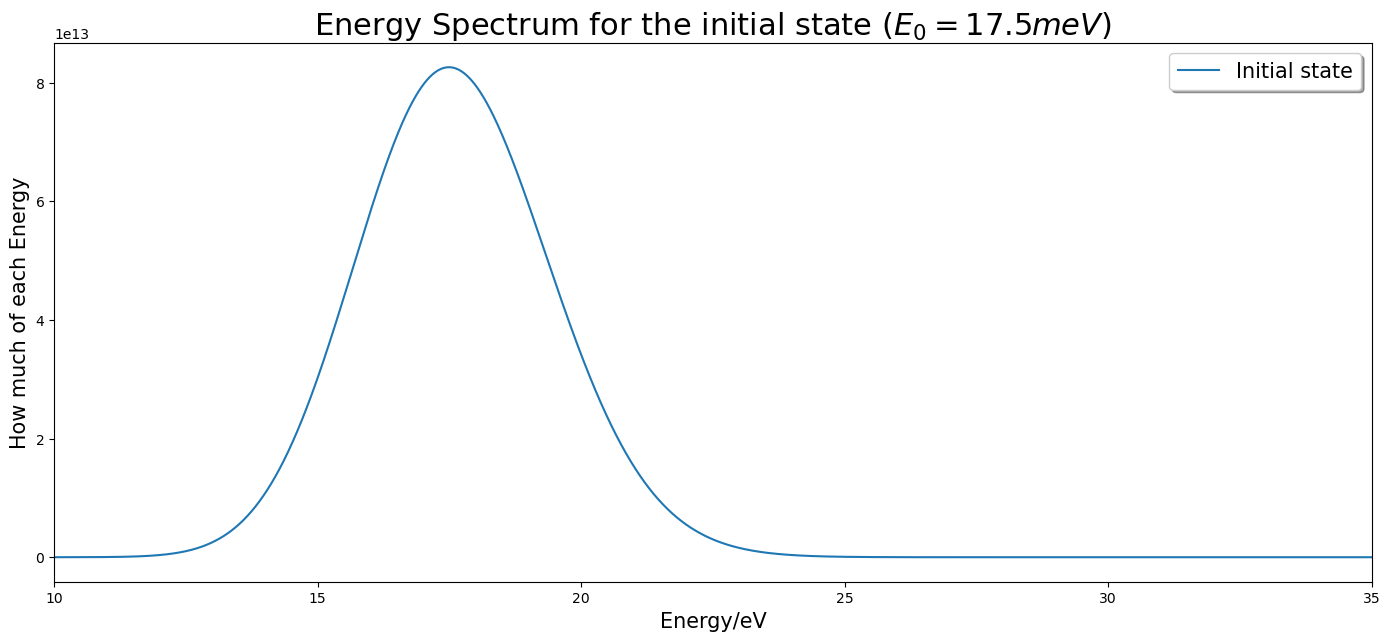

In [8]:

Energi_specture = ( (freq)* hbar)**2/(2 * m)




plt.figure(figsize=(17,7))
plt.title('Energy Spectrum for the initial state ($E_0=17.5meV$)', fontsize= 22)
# plt.plot(Energi_specture/elementary_charge, np.abs(Transformed_total)**2, label = 'Total')
plt.plot((Energi_specture)/elementary_charge*1e3, np.abs(Transformed_reflected)**2, label = 'Initial state')
plt.xlim(10, 35)
# plt.ylim(-10000,10000)
plt.xlabel('Energy/eV', fontsize= 15)
plt.ylabel('How much of each Energy', fontsize= 15)
plt.legend(shadow=True, loc='upper right', prop={'size': 15})
plt.show()

In [ ]:
(Energi_specture[np.where(Transformed_transmited==np.max(Transformed_transmited))[0][0]])/elementary_charge

In [ ]:
pot_barriers, v_max = Two_Potential_Barrier(x, dx, time_redused, Potential_size)

plt.figure(figsize=(15,7))
# plt.plot(x, np.abs(Psi_t1[-1]))
plt.plot(x, 1e23*pot_barriers)
# plt.xlim(2e-6,2.51e-6)
# plt.xlim(0,0.5e-6)
plt.xlim(1244e-9,1256e-9)

In [ ]:
print(95.8-55.25)

In [9]:
def analytical_dobbelt_barrier_transmiton(Potential, mass, hbar, k):
    #Potential_size = np.array([barrier_size, well_size, barrier_hight,0,0])
    transmition_amplitude = np.zeros(len(k))

    k_barrier = np.sqrt(2*Potential[2]*mass)/(hbar)
    #print(k_barrier, k[0])
    barrier = Potential[0]
    well = Potential[1]

    for i in range(len(k)):
        #print(k_barrier**2-k[i]**2)
        kapa = np.emath.sqrt(k_barrier**2-k[i]**2)
        sigma = kapa/k[i] + k[i]/kapa
        delta = kapa/k[i] - k[i]/kapa
        sigma2 = k_barrier**4 / (k[i]**2*kapa**2)

        a = kapa*barrier
        b = 2*k[i] * well

        D_k = np.cosh(a)**2 + 1/4 * np.sinh(a)**2 *(sigma**2 * np.cos(b)-delta**2)\
                + 1j * np.sinh(a)*(delta * np.cosh(a) + 1/4*sigma**2*np.sinh(a)*np.sin(b))

            

        transmition_amplitude[i] =np.abs( np.exp(-2j*k[i]*barrier) / D_k)
    transmition_prob = (transmition_amplitude)**2

    return  transmition_prob

def Resonance_freq(n, hbar, mass, well, E_init, elementary_charge):

    E_resonance = (n*np.pi*hbar)**2 / (2*mass * well**2)

    omega = (E_resonance - E_init) / hbar

    return E_resonance, omega
print((2*np.pi*hbar)/np.sqrt(2*m*80e-3*elementary_charge))

E_resonance, omega = Resonance_freq(2, hbar, m, well_size, Energi_init, elementary_charge)
print(omega/elementary_charge, E_resonance/elementary_charge, Energi_init/elementary_charge)


4.3360705838116594e-09
2.302463306625356e+32 0.0417811291284373 0.0175


In [ ]:

energis = np.linspace(1e-5,100e-3,500)
energis = energis * elementary_charge
k = np.sqrt(2*m*energis)/(hbar)


analytical_prob = analytical_dobbelt_barrier_transmiton(Potential_size, m, hbar, k)


transmiton_2_barier = transmition(Two_Potential_Barrier, energis, Potential_size, sigma_x, x_s, L, hbar, m)
# print(transmiton_2_barier)
plt.figure(figsize=(17,7))
plt.plot(energis/elementary_charge, analytical_prob, '-.', label = 'Analytical')
plt.plot(energis/elementary_charge, transmiton_2_barier, label = 'Numerical')
# plt.xlim(0,0.15)
plt.legend()
plt.show()

In [ ]:

energis = np.linspace(0.02,0.032,100)
energis = energis * elementary_charge
k = np.sqrt(2*m*energis)/(hbar)


analytical_prob = analytical_dobbelt_barrier_transmiton(Potential_size, m, hbar, k)


transmiton_2_barier = transmition(Two_Potential_Barrier, energis, Potential_size, sigma_x, x_s, L, hbar, m)


In [ ]:
# np.where(transmiton_2_barier==np.max(transmiton_2_barier))
# print((energis[9])/elementary_charge )

In [ ]:
plt.figure(figsize=(17,7))
plt.title('Transmission around the second resonance', fontsize=20)
plt.plot(energis/elementary_charge, analytical_prob, '-.', label = 'Analytical')
plt.plot(energis/elementary_charge, transmiton_2_barier, label = 'Numerical')
# plt.xlim(0.022,0.024)
# plt.ylim(0,0.2)
plt.xlabel('Energi / eV', fontsize=15)
plt.ylabel('Transmission Probability', fontsize=15)
plt.legend(shadow=True, loc='upper left')
plt.show()

In [ ]:

energis = np.linspace(10e-3,30e-3,30)
energis = energis * elementary_charge
k = np.sqrt(2*m*energis)/(hbar)


analytical_prob = analytical_dobbelt_barrier_transmiton(Potential_size, m, hbar, k)


transmiton_2_barier = transmition(Two_Potential_Barrier, energis, Potential_size, sigma_x, x_s, L, hbar, m)


In [ ]:
plt.figure(figsize=(17,7))
plt.plot(energis/elementary_charge, analytical_prob, '-.', label = 'Analytical')
plt.plot(energis/elementary_charge, transmiton_2_barier, label = 'Numerical')
# plt.xlim(0.009,0.022)
# plt.ylim(0,0.2)
plt.legend()
plt.show()

In [10]:
well_size = 6e-9
barrier_size = 1.2e-9
barrier_hight = 90e-3*elementary_charge


Potential_size1 = np.array([barrier_size, well_size, barrier_hight, 0,0])

energis1 = np.linspace(2e-5,0.12,10000)
energis1 = energis1 * elementary_charge
k1 = np.sqrt(2*m*energis1)/(hbar)

analytical_prob12 = analytical_dobbelt_barrier_transmiton(Potential_size1, m, hbar, k1)
print(analytical_prob12.shape,k1.shape)

(10000,) (10000,)


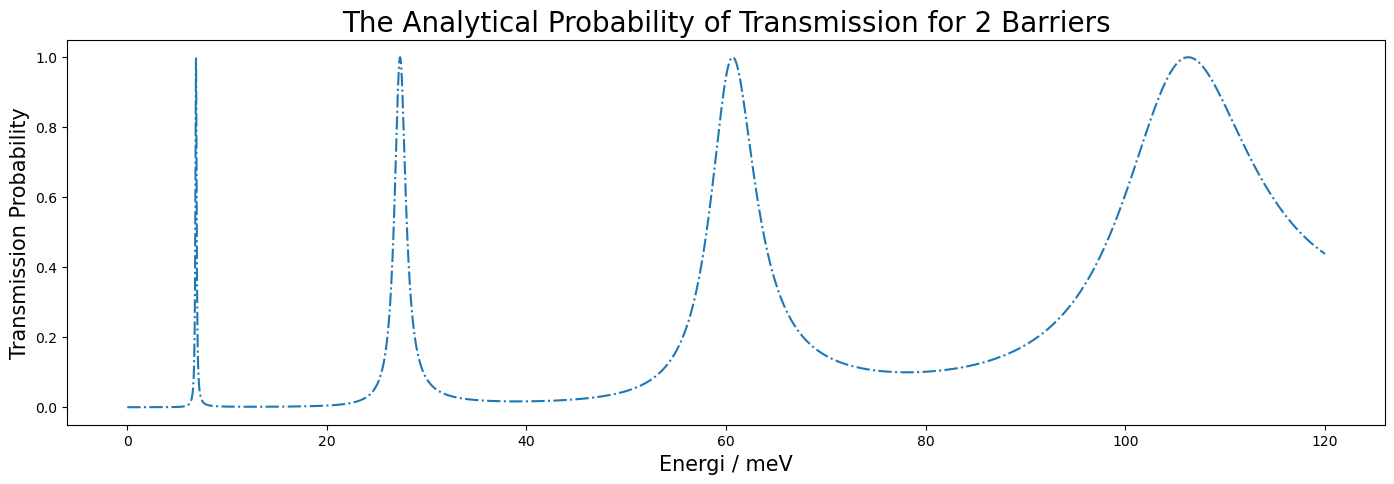

In [12]:
# u = np.zeros_like(energis1)
# u[np.searchsorted(energis1,0.02735*elementary_charge)] = 1
# u[np.searchsorted(energis1,0.02805*elementary_charge)] = 1
# u[np.searchsorted(energis1,0.02655*elementary_charge)] = 1



plt.figure(figsize=(17,5))
plt.title('The Analytical Probability of Transmission for 2 Barriers', fontsize=20)
# plt.plot(energis1/elementary_charge, u)
plt.plot(energis1/elementary_charge *1e3, analytical_prob12, '-.', label = 'Analytical')
# plt.plot(energis/elementary_charge, transmiton_2_barier, label = 'Numerical')
# plt.xlim(20,35)
plt.xlabel('Energi / meV', fontsize=15)
plt.ylabel('Transmission Probability', fontsize=15)
# plt.legend(shadow=True, loc='upper left')
plt.show()

In [ ]:
print(np.where(analytical_prob12==np.max(analytical_prob12)))
print(energis1[5054]/elementary_charge *1e3)